In [3]:
import soundfile # to read audio file
import numpy as np
import pandas as pd
import librosa # to extract speech features
import glob
import os
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model, to_categorical

In [5]:
feature_used = {
    "mfcc": True,
    "chroma": True,
    "mel": True,
    "contrast": False,
    "tonnetz": False
}

In [6]:
def extract_feature(file_name):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
    """
    mfcc = feature_used["mfcc"]
    chroma = feature_used["chroma"]
    mel = feature_used["mel"]
    contrast = feature_used["contrast"]
    tonnetz = feature_used["tonnetz"]
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        if (len(X.shape) != 1):
            if (X.shape[1] == 2):
                X = X[:,0]
            else:
                return [None]
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [7]:

int2emotion_ravdess = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

string2emotion_cremad = {
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral",
    "SAD": "sad"
}

# possible emotions (in both datasets): angry, fear, happy, neutral, sad
# only files with these emotion labels are used
emotions_dict ={
    "neutral": 0,
    "happy": 1,
    "angry": 2,
    "sad": 3,
    "fearful": 4
}

category_to_emotion = {}

for key in emotions_dict.keys():
    value = emotions_dict[key]
    category_to_emotion[value] = key

In [8]:
def load_cremad_data(test_size=0.2, max_amount=10000):
    i = 0
    X, y = [], []
    amount = 0
    for file in glob.glob("cremad-wav/*.wav"):
        if (amount >= max_amount):
            break
        
        basename = os.path.basename(file)
        emotion = string2emotion_cremad[basename.split("_")[2]]
        
        allowed_emotions = emotions_dict.keys()
        if emotion not in allowed_emotions:
            continue
        emotion_category = emotions_dict[emotion]
        features = extract_feature(file)
        
        ## there seems to be some unusable data so lets get rid of those
        if (features[0] == None):
            continue
        
        
            
        X.append(features)
        y.append(emotion_category)
        amount = amount + 1
        
    return (np.array(X), y)

In [9]:
def load_ravdess_data(test_size=0.2, max_amount=10000):
    i = 0
    X, y = [], []
    amount = 0
    for file in glob.glob("ravdess/Audio*/Actor_*/*.wav"):
        if (amount >= max_amount):
            break
        
        basename = os.path.basename(file)
        
        emotion = int2emotion_ravdess[basename.split("-")[2]]
        allowed_emotions = emotions_dict.keys()
        
        if emotion not in allowed_emotions:
            continue
        emotion_category = emotions_dict[emotion]
        
        features = extract_feature(file)
        
        ## there seems to be some unusable data so lets get rid of those
        if (features[0] == None):
            continue
        
        
            
        X.append(features)
        y.append(emotion_category)
        amount = amount + 1
        
    return (np.array(X), y)

In [10]:
max_amount_of_data_per_data_set = 10000
test_size = 0.2
# train_test_split(np.array(X), y, test_size=test_size, random_state=7)
X_ravdess, y_ravdess = load_ravdess_data(test_size=0.25, max_amount=max_amount_of_data_per_data_set)
X_cremad, y_cremad = load_ravdess_data(test_size=0.25, max_amount=max_amount_of_data_per_data_set)

X = np.concatenate((X_ravdess, X_cremad))
y = np.concatenate((y_ravdess, y_cremad))

(array([376.,   0., 752.,   0.,   0., 752.,   0., 752.,   0., 752.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

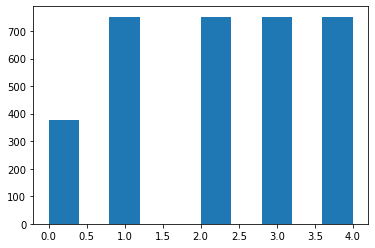

In [11]:
# shows training data distribution 
plt.hist(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=7)

In [13]:

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


y_train = np.asarray(y_train)
y_train = y_train.astype(np.float32)
y_test = np.asarray(y_test)
y_test = y_test.astype(np.float32)

nb_classes = len(emotions_dict.keys())
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

In [14]:
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Train shape", X_train.shape)
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])
# number of features used
print("[+] Number of features:", X_train.shape[1])


[+] Number of training samples: 2707
[+] Train shape (2707, 180)
[+] Number of testing samples: 677
[+] Number of features: 180


In [15]:
print("[+] X_train first value's first 5 values", X_train[0][0:5])
print("[+] y_train first value", y_train[0])

[+] X_train first value's first 5 values [-443.01126     60.77348    -22.601656    -8.195572   -12.4209585]
[+] y_train first value [0. 0. 0. 0. 1.]


# Complicated model

In [16]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
x_traincnn.shape

(2707, 180, 1)

In [17]:
inputs = keras.Input(shape=(x_traincnn.shape[1], x_traincnn.shape[2]))
x = layers.Conv1D(128, 5, activation="relu", padding="same")(inputs)

x = layers.Dropout(rate=0.1)(x)

x = layers.MaxPooling1D(pool_size=(8))(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)


output_units = len(emotions_dict.keys())
outputs = layers.Dense(units=output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
print(model.summary())

Model: "mlp_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 180, 128)          768       
_________________________________________________________________
dropout (Dropout)            (None, 180, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 22, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 128)           82048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2816)              0 

C:\Users\ossij\anaconda3\envs\ids-proj\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
epochs = 200

history = model.fit(x_traincnn, y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

Epoch 1/200
85/85 - 3s - loss: 3.5066 - accuracy: 0.2353
Epoch 2/200
85/85 - 2s - loss: 2.9798 - accuracy: 0.2482
Epoch 3/200
85/85 - 2s - loss: 2.6817 - accuracy: 0.2597
Epoch 4/200
85/85 - 2s - loss: 2.3995 - accuracy: 0.2848
Epoch 5/200
85/85 - 2s - loss: 2.1575 - accuracy: 0.2989
Epoch 6/200
85/85 - 2s - loss: 2.0117 - accuracy: 0.3003
Epoch 7/200
85/85 - 2s - loss: 1.8696 - accuracy: 0.3221
Epoch 8/200
85/85 - 2s - loss: 1.7489 - accuracy: 0.3214
Epoch 9/200
85/85 - 2s - loss: 1.6373 - accuracy: 0.3476
Epoch 10/200
85/85 - 2s - loss: 1.5735 - accuracy: 0.3583
Epoch 11/200
85/85 - 2s - loss: 1.4676 - accuracy: 0.3964
Epoch 12/200
85/85 - 2s - loss: 1.4430 - accuracy: 0.3938
Epoch 13/200
85/85 - 2s - loss: 1.4177 - accuracy: 0.4052
Epoch 14/200
85/85 - 2s - loss: 1.3968 - accuracy: 0.3982
Epoch 15/200
85/85 - 2s - loss: 1.3552 - accuracy: 0.4149
Epoch 16/200
85/85 - 2s - loss: 1.3392 - accuracy: 0.4245
Epoch 17/200
85/85 - 2s - loss: 1.3079 - accuracy: 0.4485
Epoch 18/200
85/85 - 2s

Epoch 142/200
85/85 - 2s - loss: 0.6011 - accuracy: 0.7728
Epoch 143/200
85/85 - 2s - loss: 0.5972 - accuracy: 0.7695
Epoch 144/200
85/85 - 2s - loss: 0.6024 - accuracy: 0.7736
Epoch 145/200
85/85 - 2s - loss: 0.5972 - accuracy: 0.7736
Epoch 146/200
85/85 - 2s - loss: 0.6023 - accuracy: 0.7721
Epoch 147/200
85/85 - 2s - loss: 0.5901 - accuracy: 0.7772
Epoch 148/200
85/85 - 2s - loss: 0.5890 - accuracy: 0.7750
Epoch 149/200
85/85 - 2s - loss: 0.5900 - accuracy: 0.7754
Epoch 150/200
85/85 - 2s - loss: 0.5820 - accuracy: 0.7784
Epoch 151/200
85/85 - 2s - loss: 0.5774 - accuracy: 0.7791
Epoch 152/200
85/85 - 2s - loss: 0.5819 - accuracy: 0.7824
Epoch 153/200
85/85 - 2s - loss: 0.5749 - accuracy: 0.7872
Epoch 154/200
85/85 - 2s - loss: 0.5721 - accuracy: 0.7883
Epoch 155/200
85/85 - 2s - loss: 0.5704 - accuracy: 0.7820
Epoch 156/200
85/85 - 2s - loss: 0.5719 - accuracy: 0.7795
Epoch 157/200
85/85 - 2s - loss: 0.5545 - accuracy: 0.7868
Epoch 158/200
85/85 - 2s - loss: 0.5648 - accuracy: 0.78

# Simple model

In [ ]:
inputs = keras.Input(shape=(X_train.shape[1], ))
x = layers.Dense(28)(inputs)
x = layers.Dense(28)(x)

output_units = len(emotions_dict.keys())
outputs = layers.Dense(units=output_units, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs,
                    name="mlp_model")
opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])
print(model.summary())

In [ ]:
epochs = 200

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=32,
                    verbose=2)

## Evaluating on data

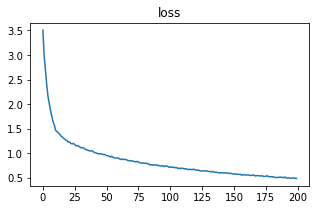

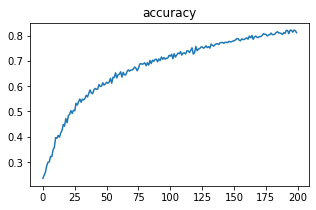

In [19]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'])
plt.title('accuracy');

In [20]:
scores = model.evaluate(x_testcnn, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

22/22 - 0s - loss: 0.5269 - accuracy: 0.8183
accuracy: 81.83%


In [21]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(x_testcnn)
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
emotions = len(emotions_dict.keys())
cm=confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), labels=list(range(emotions)))
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print(f"{i} ({category_to_emotion[i]}): {j}")

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 51   2   0  17   4]
 [  2 107   7   3  20]
 [  1   3 127   2   7]
 [  5   4   3 138  25]
 [  0   3   3  12 131]]

Classification accuracy for each class:

0 (neutral): 0.6891891891891891
1 (happy): 0.7697841726618705
2 (angry): 0.9071428571428571
3 (sad): 0.7885714285714286
4 (fearful): 0.8791946308724832


# Testing on youtube videos

In [22]:
from pydub import AudioSegment
from pydub.utils import mediainfo
import math
import shutil


In [23]:
def rm_folder(path):
    try:
        shutil.rmtree(path)
    except:
        None

In [24]:
#
# 768kbs
## split each video to 3 second videos and save them to folders predictions to those
for file in glob.glob("test_yt_data/*.mp3"):
        file_splits = []
        file_path = os.getcwd() + "\\" + file
        basename = os.path.basename(file)
        basename_without_ext = basename.split(".")[0]
        split_folder_name = f"{basename_without_ext}_split"
        sound = AudioSegment.from_file(file)
        
        parent_dir = os.getcwd() + "\\test_yt_data"
        path_to_splits = os.path.join(parent_dir, split_folder_name)
        
        rm_folder(path_to_splits)
        os.mkdir(path_to_splits, 0o666)
                 
        i = 0
        three_seconds = 3 * 1000
        length = len(sound)
        splits_amount = math.ceil(length/three_seconds)
        while (i < splits_amount):
            start_index = i * three_seconds
            end_index = start_index + three_seconds
            split = sound[start_index:end_index]
            split_video_name = f"{basename_without_ext}_split_{i}-{i + 3}.wav"
            path = f"test_yt_data/{split_folder_name}/{split_video_name}"
            
            split.export(path, format='wav', bitrate="768000")
            i = i + 1
        
        


In [25]:
folder_containing_splits = "\\How to tie a tie 1 minute tutorial_split"

folder_name = os.getcwd() + "\\test_yt_data" + folder_containing_splits
df_emotions = pd.DataFrame(columns=['file_name', 'emotion', 'start_time', 'emotion_class', 'confidence'])

for file in os.listdir(folder_name):
    file_name = os.fsdecode(file)
    path = folder_name + "\\" + file_name
    features = extract_feature(path)
    features = np.expand_dims(features, axis=1)
    features = np.expand_dims(features, axis=0)
    features = features.astype(np.float32)
    
    start_time = file_name.split('_')[len(file_name.split('_'))-1].split('-')[0]
    
    predic = model.predict(features)
    predic_confidence = float(np.amax(predic,1)[0])

    emotion = category_to_emotion[np.argmax(predic)]
    emotion_class = emotions_dict[emotion]
    

    new_row = {'file_name': file_name,
               'emotion': emotion,
              'start_time': int(start_time),
              'emotion_class': emotion_class,
              'confidence': predic_confidence}
    df_emotions = df_emotions.append(new_row, ignore_index=True)

df_emotions.sort_values(by='start_time', inplace=True)

C:\Users\ossij\anaconda3\envs\ids-proj\lib\site-packages\librosa\core\pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


<AxesSubplot:>

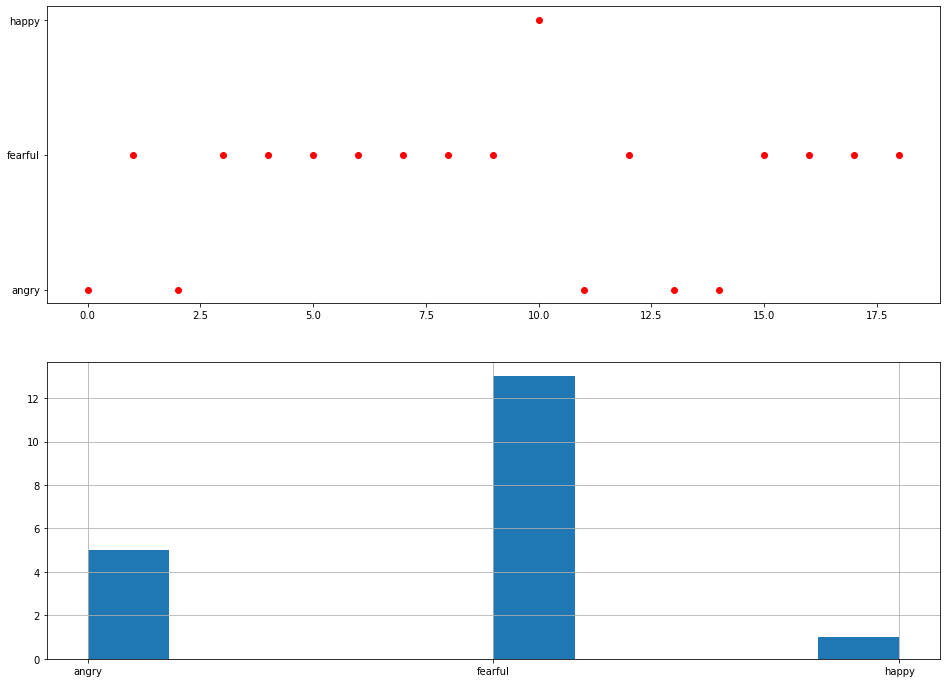

In [26]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (16,12))
plt.subplot(2,1,1)
plt.plot(np.array(df_emotions['emotion']), 'ro')
plt.subplot(2,1,2)
df_emotions['emotion'].hist()

In [30]:
df_emotions.where(df_emotions['emotion']=='angry').dropna()

,file_name,emotion,start_time,emotion_class,confidence
0,How to tie a tie 1 minute tutorial_split_0-3.wav,angry,0,2,0.510061
11,How to tie a tie 1 minute tutorial_split_2-5.wav,angry,2,2,0.981134
3,How to tie a tie 1 minute tutorial_split_11-14...,angry,11,2,0.931406
5,How to tie a tie 1 minute tutorial_split_13-16...,angry,13,2,0.567616
6,How to tie a tie 1 minute tutorial_split_14-17...,angry,14,2,0.946468
